## Objective 3 - Forecast of the number of the terminals with a neural network

- André Novo
- Beatriz Paulino
- Catarina Brito 
- Luís Pereira 

In [1]:
# Used Libraries 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from shapely.geometry import GeometryCollection, box
from shapely.wkt import loads

### Reading datasets - Data
- June 
- July 
- august

|Column    | Type| Description |
|:---:|:---:| :---:| 
| **Grid_ID** | Int | Grid Identifier |
| **C1** | Float | Number of distinct terminals in the grid |
| **C2** | Float | Number of distinct terminals, in <u>roaming</u>, in the grid |
| **C3** | Float | Number of distinct terminals that remained in the grid |
| **C4** | Float | Number of distinct terminals, in <u>roaming</u>, that remained in the grid |
| **E8** | Float | Average duration of stay in the grid |

##### SKIP IF YOU ALREADY HAVE TOURISM_LSTM.CSV

In [ ]:
root = os.getcwd()
path = os.path.join(root, "data")
# all_files = glob.glob(path + "/*.csv")
df = pd.read_csv(os.path.join(path, 'tourism_hourly.csv'), encoding='ISO-8859-1', index_col=0, parse_dates=True)

C:\Users\Utilizador\AppData\Local\Temp\ipykernel_15892\1368208703.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(os.path.join(path, 'tourism_hourly.csv'), encoding='ISO-8859-1', index_col=0, parse_dates=True)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2278560 entries, 301 to 3743
Data columns (total 14 columns):
 #   Column        Dtype  
---  ------        -----  
 0   new_datetime  object 
 1   C1            float64
 2   C2            float64
 3   C3            float64
 4   C4            float64
 5   E8            float64
 6   D1            object 
 7   freguesia     object 
 8   nome          object 
 9   Grid_ID.1     float64
 10  wkt           object 
 11  latitude      float64
 12  longitude     float64
 13  position      object 
dtypes: float64(8), object(6)
memory usage: 260.8+ MB


In [ ]:
df.isnull().sum()

new_datetime        0
C1                  0
C2                  0
C3                  0
C4                  0
E8                  0
D1              74592
freguesia       74592
nome            74592
Grid_ID.1       74592
wkt             74592
latitude        74592
longitude       74592
position        74592
dtype: int64

Data Preprocessing and Feature Engineering

In [ ]:
# drop column D1, has nulls
df.drop(['D1'], axis=1, inplace=True)

In [ ]:
# date index
df.set_index('new_datetime', inplace=True)

In [ ]:
df.head()

,C1,C2,C3,C4,E8,freguesia,nome,Grid_ID.1,wkt,latitude,longitude,position
new_datetime,,,,,,,,,,,,
2022-06-01 00:00:00,43.02,3.73,37.86,3.73,44.65,MisericÃ³rdia,Faixa Ribeirinha de Santos,301.0,MULTIPOLYGON (((-9.15046406286248 38.704011448...,38.704714,-9.151365,"{'type': 'GeometryCollection', 'geometries': [..."
2022-06-01 01:00:00,90.39,13.16,89.12,13.16,41.07,MisericÃ³rdia,Faixa Ribeirinha de Santos,301.0,MULTIPOLYGON (((-9.15046406286248 38.704011448...,38.704714,-9.151365,"{'type': 'GeometryCollection', 'geometries': [..."
2022-06-01 02:00:00,92.75,20.45,88.27,18.91,52.55,MisericÃ³rdia,Faixa Ribeirinha de Santos,301.0,MULTIPOLYGON (((-9.15046406286248 38.704011448...,38.704714,-9.151365,"{'type': 'GeometryCollection', 'geometries': [..."
2022-06-01 03:00:00,125.63,18.83,125.12,18.83,667.22,MisericÃ³rdia,Faixa Ribeirinha de Santos,301.0,MULTIPOLYGON (((-9.15046406286248 38.704011448...,38.704714,-9.151365,"{'type': 'GeometryCollection', 'geometries': [..."
2022-06-01 04:00:00,37.22,1.75,31.02,1.75,40.08,MisericÃ³rdia,Faixa Ribeirinha de Santos,301.0,MULTIPOLYGON (((-9.15046406286248 38.704011448...,38.704714,-9.151365,"{'type': 'GeometryCollection', 'geometries': [..."


In [ ]:
df.drop(['nome', 'position', 'wkt', 'freguesia','latitude','longitude'], axis=1, inplace=True)

In [ ]:
df.head()

,C1,C2,C3,C4,E8,Grid_ID.1
new_datetime,,,,,,
2022-06-01 00:00:00,43.02,3.73,37.86,3.73,44.65,301.0
2022-06-01 01:00:00,90.39,13.16,89.12,13.16,41.07,301.0
2022-06-01 02:00:00,92.75,20.45,88.27,18.91,52.55,301.0
2022-06-01 03:00:00,125.63,18.83,125.12,18.83,667.22,301.0
2022-06-01 04:00:00,37.22,1.75,31.02,1.75,40.08,301.0


In [ ]:
# rename grid_id.1 to grid_id
df.rename(columns={'Grid_ID.1':'Grid_ID'}, inplace=True)

In [ ]:
df.head()

,C1,C2,C3,C4,E8,Grid_ID
new_datetime,,,,,,
2022-06-01 00:00:00,43.02,3.73,37.86,3.73,44.65,301.0
2022-06-01 01:00:00,90.39,13.16,89.12,13.16,41.07,301.0
2022-06-01 02:00:00,92.75,20.45,88.27,18.91,52.55,301.0
2022-06-01 03:00:00,125.63,18.83,125.12,18.83,667.22,301.0
2022-06-01 04:00:00,37.22,1.75,31.02,1.75,40.08,301.0


##### LSTM

In [ ]:
file_path = os.path.join(root, 'tourism_lstm.csv')

if not os.path.exists(file_path):
    df.to_csv(file_path, index=True)
else:
    print(f"The file '{file_path}' already exists.")

The file 'e:\Faculdade\Mestrado\UCs\IOT\Tourist-Concentration-Zone-Management\tourism_lstm.csv' already exists.


In [ ]:
df = pd.read_csv(file_path, index_col=0, parse_dates=True)

In [ ]:
df.head()

,C1,C2,C3,C4,E8,Grid_ID
new_datetime,,,,,,
2022-06-01 00:00:00,43.02,3.73,37.86,3.73,44.65,301.0
2022-06-01 01:00:00,90.39,13.16,89.12,13.16,41.07,301.0
2022-06-01 02:00:00,92.75,20.45,88.27,18.91,52.55,301.0
2022-06-01 03:00:00,125.63,18.83,125.12,18.83,667.22,301.0
2022-06-01 04:00:00,37.22,1.75,31.02,1.75,40.08,301.0


In [ ]:
# reproducibility
tf.random.set_seed(5)

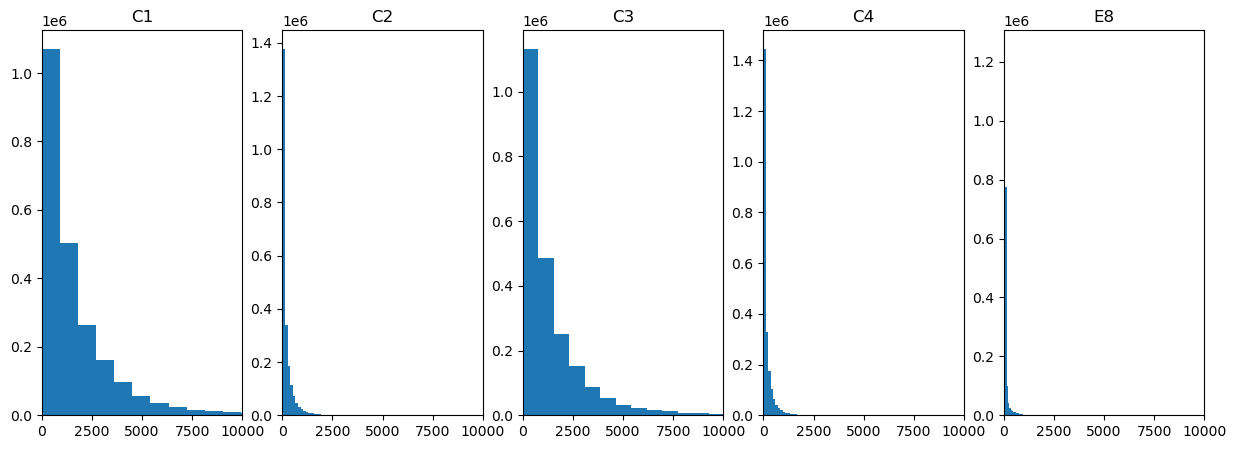

In [ ]:
# Check distributions of the variables
feature_cols = ['C1', 'C2', 'C3', 'C4', 'E8']
plt.figure(figsize=(15, 5))

# lets separate histograms by variable in feature_cols with subplots
for i in range(len(feature_cols)):
    plt.subplot(1, 5, i+1)
    plt.hist(df[feature_cols[i]], bins=100)
    plt.title(feature_cols[i])
    plt.xlim((0, 10000))
plt.show()

In [ ]:
# Pivot the DataFrame
df_pivoted = df.pivot_table(index=df.index, columns='Grid_ID', values=feature_cols)

In [2]:
df_pivoted.head()

NameError: name 'df_pivoted' is not defined

In [19]:
scaler = MinMaxScaler(feature_range=(0, 1))
# Normalize data for each grid
for grid_id in df_pivoted.columns.levels[1]:  # Assuming grid_id is the second level of the columns
    # Selecting the grid data
    grid_data = df_pivoted.xs(grid_id, level='Grid_ID', axis=1)

    # Applying normalization
    df_pivoted.loc[:, pd.IndexSlice[:, grid_id]] = scaler.fit_transform(grid_data)

In [20]:
df_pivoted.head()   

C1                                          \
Grid_ID                301.0     302.0     303.0     304.0     305.0    
new_datetime                                                            
2022-06-01 00:00:00  0.019831  0.069309  0.108874  0.202398  0.120817   
2022-06-01 01:00:00  0.045847  0.089027  0.061251  0.222736  0.052969   
2022-06-01 02:00:00  0.047143  0.120967  0.067115  0.086062  0.041011   
2022-06-01 03:00:00  0.065200  0.029609  0.060535  0.026022  0.067206   
2022-06-01 04:00:00  0.016646  0.013029  0.052364  0.044843  0.024810   

                                                                       ...  \
Grid_ID                347.0     348.0     349.0     350.0     351.0   ...   
new_datetime                                                           ...   
2022-06-01 00:00:00  0.099910  0.038910  0.127924  0.339785  0.318829  ...   
2022-06-01 01:00:00  0.039120  0.031829  0.102761  0.230814  0.307434  ...   
2022-06-01 02:00:00  0.022421  0.021741  0.039930  0.194635  0.211479  ...   
2022-06-01 03:00:00  0.028145  0.018415  0.029354  0.179435  0.178987  ...   
2022-06-01 04:00:00  0.029499  0.027720  0.030097  0.175534  0.159960  ...   

                           E8                                          \
Grid_ID                3732.0    3733.0    3736.0    3737.0    3738.0   
new_datetime                                                            
2022-06-01 00:00:00  0.008709  0.030425  0.236006  0.015916  0.025589   
2022-06-01 01:00:00  0.000129  0.123508  0.139811  0.144663  0.022353   
2022-06-01 02:00:00  0.002005  0.018580  0.081595  0.310405  0.023898   
2022-06-01 03:00:00  0.002061  0.133838  0.077395  0.134917  0.014874   
2022-06-01 04:00:00  0.000000  0.164264  0.101852  0.070785  0.033192   

                                                                       
Grid_ID                3739.0    3740.0    3741.0    3742.0    3743.0  
new_datetime                                                           
2022-06-01 00:00:00  0.022628  0.007062  0.058892  0.004321  0.002869  
2022-06-01 01:00:00  0.005774  0.064972  0.169857  0.006554  0.034306  
2022-06-01 02:00:00  0.031773  0.000000  0.081248  0.003500  0.026803  
2022-06-01 03:00:00  0.056111  0.000000  0.089274  0.031452  0.050278  
2022-06-01 04:00:00  0.006130  0.000000  0.122936  0.000000  0.005167  

[5 rows x 5180 columns]

In [21]:
df_june = df_pivoted[df_pivoted.index.month == 6]
df_july = df_pivoted[df_pivoted.index.month == 7]
df_aug = df_pivoted[df_pivoted.index.month == 8]

In [22]:
def create_sequences_for_grid(data, grid_id, seq_length):
    sequences = []
    targets = []
    dates = []

    # Select the data for the specified grid
    grid_data = data.xs(grid_id, level='Grid_ID', axis=1)

    for i in range(len(grid_data) - seq_length):
        seq = grid_data[i:i + seq_length].values
        target = grid_data[i + seq_length:i + seq_length + 1].values
        seq_end_date = grid_data.index[i + seq_length - 1]  # Last date in the sequence
        sequences.append(seq)
        targets.append(target)
        dates.append(seq_end_date)

    return np.array(sequences), np.array(targets), dates

In [23]:
def split_train_test(sequences, targets, dates, test_size_ratio):
    train_sequences = {}
    test_sequences = {}
    train_targets = {}
    test_targets = {}
    train_dates = {}
    test_dates = {}

    for grid_id in sequences.keys():
        test_size = int(len(sequences[grid_id]) * test_size_ratio)

        # Split sequences and targets for test and train sets
        X_test, y_test = sequences[grid_id][-test_size:], targets[grid_id][-test_size:].squeeze()
        X_train, y_train = sequences[grid_id][:-test_size], targets[grid_id][:-test_size].squeeze()

        # Split dates for test and train sets
        test_date = dates[grid_id][-test_size:]
        train_date = dates[grid_id][:-test_size]

        # Check if reshape is necessary for LSTM input
        if X_train.ndim == 2:
            X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
            X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

        # Store the split data and dates
        train_sequences[grid_id] = X_train
        test_sequences[grid_id] = X_test
        train_targets[grid_id] = y_train
        test_targets[grid_id] = y_test
        train_dates[grid_id] = train_date
        test_dates[grid_id] = test_date

        # Print shapes
        print(f"Grid ID: {grid_id}")
        print("Shape of training data:", train_sequences[grid_id].shape, train_targets[grid_id].shape)
        print("Shape of test data:", test_sequences[grid_id].shape, test_targets[grid_id].shape)

    return train_sequences, test_sequences, train_targets, test_targets, train_dates, test_dates

Parameters

In [36]:
test_size_ratio = 0.3  # Adjust as necessary
seq_length = 7*24  # Adjust as necessary

June Preparation

In [37]:
df_june.head()

C1                                          \
Grid_ID                301.0     302.0     303.0     304.0     305.0    
new_datetime                                                            
2022-06-01 00:00:00  0.019831  0.069309  0.108874  0.202398  0.120817   
2022-06-01 01:00:00  0.045847  0.089027  0.061251  0.222736  0.052969   
2022-06-01 02:00:00  0.047143  0.120967  0.067115  0.086062  0.041011   
2022-06-01 03:00:00  0.065200  0.029609  0.060535  0.026022  0.067206   
2022-06-01 04:00:00  0.016646  0.013029  0.052364  0.044843  0.024810   

                                                                       ...  \
Grid_ID                347.0     348.0     349.0     350.0     351.0   ...   
new_datetime                                                           ...   
2022-06-01 00:00:00  0.099910  0.038910  0.127924  0.339785  0.318829  ...   
2022-06-01 01:00:00  0.039120  0.031829  0.102761  0.230814  0.307434  ...   
2022-06-01 02:00:00  0.022421  0.021741  0.039930  0.194635  0.211479  ...   
2022-06-01 03:00:00  0.028145  0.018415  0.029354  0.179435  0.178987  ...   
2022-06-01 04:00:00  0.029499  0.027720  0.030097  0.175534  0.159960  ...   

                           E8                                          \
Grid_ID                3732.0    3733.0    3736.0    3737.0    3738.0   
new_datetime                                                            
2022-06-01 00:00:00  0.008709  0.030425  0.236006  0.015916  0.025589   
2022-06-01 01:00:00  0.000129  0.123508  0.139811  0.144663  0.022353   
2022-06-01 02:00:00  0.002005  0.018580  0.081595  0.310405  0.023898   
2022-06-01 03:00:00  0.002061  0.133838  0.077395  0.134917  0.014874   
2022-06-01 04:00:00  0.000000  0.164264  0.101852  0.070785  0.033192   

                                                                       
Grid_ID                3739.0    3740.0    3741.0    3742.0    3743.0  
new_datetime                                                           
2022-06-01 00:00:00  0.022628  0.007062  0.058892  0.004321  0.002869  
2022-06-01 01:00:00  0.005774  0.064972  0.169857  0.006554  0.034306  
2022-06-01 02:00:00  0.031773  0.000000  0.081248  0.003500  0.026803  
2022-06-01 03:00:00  0.056111  0.000000  0.089274  0.031452  0.050278  
2022-06-01 04:00:00  0.006130  0.000000  0.122936  0.000000  0.005167  

[5 rows x 5180 columns]

In [38]:
# Iterate over each grid and create sequences
june_sequences = {}
june_targets = {}
june_dates = {}

for grid_id in df_june.columns.levels[1]:
    X, y, dates = create_sequences_for_grid(df_june, grid_id, seq_length)
    june_sequences[grid_id] = X
    june_targets[grid_id] = y
    june_dates[grid_id] = dates

In [39]:
# Split the data into train and test sets, including the dates
june_train_sequences, june_test_sequences, june_train_targets, june_test_targets, june_train_dates, june_test_dates = split_train_test(june_sequences, june_targets, june_dates, test_size_ratio)

Grid ID: 301.0
Shape of training data: (336, 168, 5) (336, 5)
Shape of test data: (144, 168, 5) (144, 5)
Grid ID: 302.0
Shape of training data: (336, 168, 5) (336, 5)
Shape of test data: (144, 168, 5) (144, 5)
Grid ID: 303.0
Shape of training data: (336, 168, 5) (336, 5)
Shape of test data: (144, 168, 5) (144, 5)
Grid ID: 304.0
Shape of training data: (336, 168, 5) (336, 5)
Shape of test data: (144, 168, 5) (144, 5)
Grid ID: 305.0
Shape of training data: (336, 168, 5) (336, 5)
Shape of test data: (144, 168, 5) (144, 5)
Grid ID: 347.0
Shape of training data: (336, 168, 5) (336, 5)
Shape of test data: (144, 168, 5) (144, 5)
Grid ID: 348.0
Shape of training data: (336, 168, 5) (336, 5)
Shape of test data: (144, 168, 5) (144, 5)
Grid ID: 349.0
Shape of training data: (336, 168, 5) (336, 5)
Shape of test data: (144, 168, 5) (144, 5)
Grid ID: 350.0
Shape of training data: (336, 168, 5) (336, 5)
Shape of test data: (144, 168, 5) (144, 5)
Grid ID: 351.0
Shape of training data: (336, 168, 5) (3

In [40]:
june_train_sequences

{301.0: array([[[0.0198314 , 0.01175136, 0.02654657, 0.0233373 , 0.02401713],
         [0.04584672, 0.04146057, 0.06345401, 0.08233748, 0.02209145],
         [0.04714282, 0.06442771, 0.062842  , 0.11831321, 0.02826652],
         ...,
         [0.13767746, 0.04599729, 0.13527447, 0.06394294, 0.02981028],
         [0.13641431, 0.04253174, 0.14625454, 0.06600763, 0.02423229],
         [0.22360985, 0.04457957, 0.19600686, 0.02959394, 0.01661566]],
 
        [[0.04584672, 0.04146057, 0.06345401, 0.08233748, 0.02209145],
         [0.04714282, 0.06442771, 0.062842  , 0.11831321, 0.02826652],
         [0.06520032, 0.0593239 , 0.08937417, 0.11781268, 0.35889602],
         ...,
         [0.13641431, 0.04253174, 0.14625454, 0.06600763, 0.02423229],
         [0.22360985, 0.04457957, 0.19600686, 0.02959394, 0.01661566],
         [0.25343109, 0.01527992, 0.20651892, 0.02008384, 0.01653497]],
 
        [[0.04714282, 0.06442771, 0.062842  , 0.11831321, 0.02826652],
         [0.06520032, 0.0593239 , 0.

July Preparation

In [41]:
df_july.head()

C1                                          \
Grid_ID                301.0     302.0     303.0     304.0     305.0    
new_datetime                                                            
2022-07-01 00:00:00  0.308664  0.164912  0.149363  0.217538  0.066572   
2022-07-01 01:00:00  0.347579  0.187126  0.133385  0.235713  0.062455   
2022-07-01 02:00:00  0.385611  0.273421  0.097404  0.189601  0.056656   
2022-07-01 03:00:00  0.372414  0.168368  0.051863  0.112384  0.072762   
2022-07-01 04:00:00  0.420216  0.166720  0.097659  0.145548  0.022360   

                                                                       ...  \
Grid_ID                347.0     348.0     349.0     350.0     351.0   ...   
new_datetime                                                           ...   
2022-07-01 00:00:00  0.155578  0.304941  0.443857  0.381601  0.418029  ...   
2022-07-01 01:00:00  0.169179  0.555622  0.354729  0.310972  0.390451  ...   
2022-07-01 02:00:00  0.180510  0.670847  0.261017  0.213179  0.253690  ...   
2022-07-01 03:00:00  0.175751  0.677413  0.248946  0.137655  0.211827  ...   
2022-07-01 04:00:00  0.180446  0.618344  0.183228  0.043080  0.135834  ...   

                           E8                                                 \
Grid_ID                3732.0 3733.0    3736.0    3737.0    3738.0    3739.0   
new_datetime                                                                   
2022-07-01 00:00:00  0.000000    0.0  0.064140  0.136052  0.047009  0.049064   
2022-07-01 01:00:00  0.000000    0.0  0.078689  0.050160  0.040453  0.013733   
2022-07-01 02:00:00  0.003386    0.0  0.062528  0.065678  0.021165  0.000000   
2022-07-01 03:00:00  0.002370    0.0  0.046840  0.055465  0.065394  0.000000   
2022-07-01 04:00:00  0.000000    0.0  0.064325  0.027803  0.064611  0.000000   

                                                             
Grid_ID                3740.0    3741.0    3742.0    3743.0  
new_datetime                                                 
2022-07-01 00:00:00  0.025424  0.368225  0.007022  0.008447  
2022-07-01 01:00:00  0.067797  0.357054  0.015334  0.003008  
2022-07-01 02:00:00  0.071681  0.441501  0.024970  0.000000  
2022-07-01 03:00:00  0.099294  0.143014  0.044294  0.000000  
2022-07-01 04:00:00  0.000000  0.040604  0.060499  0.000000  

[5 rows x 5180 columns]

In [42]:
# Iterate over each grid and create sequences
july_sequences = {}
july_targets = {}
july_dates = {}

for grid_id in df_july.columns.levels[1]:
    X, y, dates = create_sequences_for_grid(df_july, grid_id, seq_length)
    july_sequences[grid_id] = X
    july_targets[grid_id] = y
    july_dates[grid_id] = dates

In [43]:
july_train_sequences, july_test_sequences, july_train_targets, july_test_targets = split_train_test(july_sequences, july_targets, test_size_ratio)

TypeError: split_train_test() missing 1 required positional argument: 'test_size_ratio'

August Preparation

In [ ]:
df_aug.head()

C1                                          \
Grid_ID                301.0     302.0     303.0     304.0     305.0    
new_datetime                                                            
2022-08-01 00:00:00  0.062443  0.223005  0.180842  0.236918  0.120144   
2022-08-01 01:00:00  0.034176  0.129669  0.087575  0.118448  0.096641   
2022-08-01 02:00:00  0.061125  0.111847  0.052235  0.055078  0.064936   
2022-08-01 03:00:00  0.061642  0.139431  0.081270  0.083789  0.070242   
2022-08-01 04:00:00  0.048928  0.056080  0.050546  0.135140  0.059231   

                                                                       ...  \
Grid_ID                347.0     348.0     349.0     350.0     351.0   ...   
new_datetime                                                           ...   
2022-08-01 00:00:00  0.064788  0.125753  0.264480  0.299793  0.232778  ...   
2022-08-01 01:00:00  0.051071  0.132461  0.168282  0.252856  0.214796  ...   
2022-08-01 02:00:00  0.044092  0.114767  0.146065  0.177956  0.185082  ...   
2022-08-01 03:00:00  0.020963  0.104372  0.079376  0.118335  0.134490  ...   
2022-08-01 04:00:00  0.018165  0.074075  0.135690  0.069462  0.094059  ...   

                           E8                                                 \
Grid_ID                3732.0 3733.0    3736.0    3737.0    3738.0    3739.0   
new_datetime                                                                   
2022-08-01 00:00:00  0.010822    0.0  0.029601  0.047862  0.042756  0.061798   
2022-08-01 01:00:00  0.000000    0.0  0.051655  0.082446  0.012966  0.032253   
2022-08-01 02:00:00  0.002912    0.0  0.062888  0.134960  0.001779  0.000000   
2022-08-01 03:00:00  0.004947    0.0  0.016007  0.122704  0.006498  0.000000   
2022-08-01 04:00:00  0.000000    0.0  0.004189  0.118023  0.000000  0.001561   

                                                             
Grid_ID                3740.0    3741.0    3742.0    3743.0  
new_datetime                                                 
2022-08-01 00:00:00  0.009887  0.121987  0.004854  0.002153  
2022-08-01 01:00:00  0.000000  0.089680  0.001801  0.000000  
2022-08-01 02:00:00  0.000000  0.009260  0.000000  0.000000  
2022-08-01 03:00:00  0.021893  0.001356  0.006302  0.039861  
2022-08-01 04:00:00  0.000000  0.000908  0.015636  0.000000  

[5 rows x 5180 columns]

In [ ]:
# Iterate over each grid and create sequences
aug_sequences = {}
aug_targets = {}
aug_dates = {}

for grid_id in df_aug.columns.levels[1]:
    X, y, dates = create_sequences_for_grid(df_aug, grid_id, seq_length)
    aug_sequences[grid_id] = X
    aug_targets[grid_id] = y
    aug_dates[grid_id] = dates

In [ ]:
aug_train_sequences, aug_test_sequences, aug_train_targets, aug_test_targets = split_train_test(aug_sequences, aug_targets, test_size_ratio)

In [ ]:
def model_grids(train_sequences, train_targets, test_sequences, test_targets, train_dates, test_dates, seq_length, scaler=scaler, grid_ids=None, num_epochs=50, batch_size=32):
    results = {}
    models = {}

    # If no specific grid IDs are provided, model all grids
    if grid_ids is None:
        grid_ids = list(train_sequences.keys())

    for grid_id in grid_ids:
        print(f"Training model for Grid ID: {grid_id}")

        # Create the LSTM model
        model = Sequential()
        model.add(LSTM(50, activation='relu', input_shape=(seq_length, 5)))
        model.add(Dense(5))
        model.compile(optimizer='adam', loss='mean_squared_error')

        # Train the model
        X_train_grid = train_sequences[grid_id]
        y_train_grid = train_targets[grid_id]
        X_test_grid = test_sequences[grid_id]
        y_test_grid = test_targets[grid_id]

        history = model.fit(X_train_grid, y_train_grid, epochs=num_epochs, batch_size=batch_size, 
                            validation_data=(X_test_grid, y_test_grid), verbose=1)

        # Predictions for the test data
        test_predictions = model.predict(X_test_grid)

        # Ensure test_predictions are in the correct shape for inverse transformation
        # This step depends on the shape that the scaler was fit on
        test_predictions_reshaped = test_predictions.reshape(-1, 5)  # Reshape to match the original feature count
        y_test_grid_reshaped = y_test_grid.reshape(-1, 5)  # Same reshaping for actual values

        # Apply inverse transformation
        test_predictions_inv = scaler.inverse_transform(test_predictions_reshaped)
        y_test_grid_inv = scaler.inverse_transform(y_test_grid_reshaped)

        # Extract the relevant feature(s) from the denormalized data
        # This step depends on which feature(s) your model is predicting
        test_predictions_final = test_predictions_inv[:, 0]  # Assuming the model predicts the first feature
        y_test_grid_final = y_test_grid_inv[:, 0]  # Same for actual values

        # Align the test dates with the predictions
        test_prediction_dates = test_dates[grid_id][-len(test_predictions_final):]

        # Create a DataFrame for dates and actual values
        df_resultados = pd.DataFrame({
            'Real': y_test_grid_final,
            'Previsto': test_predictions_final
        }, index=test_prediction_dates)

        # Store results and model
        results[grid_id] = df_resultados
        models[grid_id] = model

        # Visualize the data
        plt.figure(figsize=(8, 4))
        plt.plot(df_resultados.index, df_resultados['Real'], label='Teste (real)')
        plt.plot(df_resultados.index, df_resultados['Previsto'], label='Teste (previsão)', linestyle='dashed')
        plt.title(f'Previsões para os dados de teste - Grid ID: {grid_id}')
        plt.xlabel('Data')
        plt.ylabel('Valor')
        plt.legend()
        plt.xticks(rotation=45)
        plt.show()

    return models, results

In [ ]:
# save df_june index in a matrix and flatten it
june_index = df_june.index.values.flatten()
len(june_index)

648

Training model for Grid ID: 301.0
Epoch 1/50
11/11 [==============================] - 1s 27ms/step - loss: 0.0216 - val_loss: 0.0114
Epoch 2/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0135 - val_loss: 0.0070
Epoch 3/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0089 - val_loss: 0.0067
Epoch 4/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0091 - val_loss: 0.0066
Epoch 5/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0086 - val_loss: 0.0060
Epoch 6/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0084 - val_loss: 0.0059
Epoch 7/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0084 - val_loss: 0.0061
Epoch 8/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0081 - val_loss: 0.0057
Epoch 9/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0080 - val_loss: 0.0056
Epoch 10/50
11/11 [==============================] - 0s 6ms/step - loss: 0.0078 - v

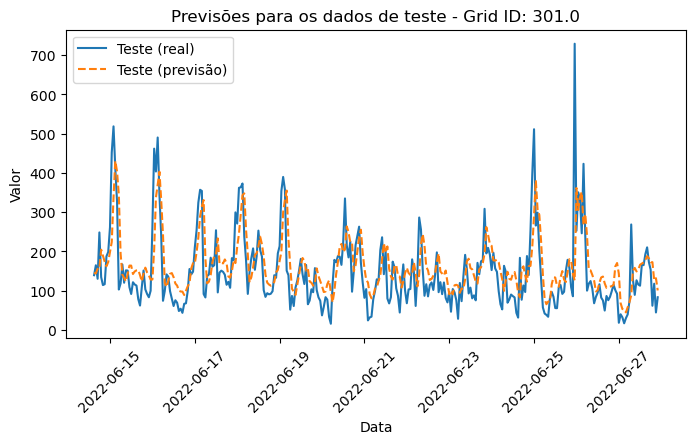

In [ ]:
# Example usage
models, results = model_grids(june_train_sequences, june_train_targets, june_test_sequences, june_test_targets, june_train_dates, june_test_dates, seq_length=7, grid_ids=[301.0])
# If you want to specify grid IDs:
# models, results = model_grids(train_sequences, train_targets, test_sequences, test_targets, seq_length=365, grid_ids=['Grid1', 'Grid2'])